## Предсказание временного ряда, выбор гиперпараметров методом дифференциальной эволюции и симплекс-методом

Данные предстваляют из себя набор исторических данных ETF фонда AMRE Московской биржи. Задача предсказать значение фонда на следующие 14 дней

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
from scipy import stats
import seaborn as sns
import os
from prophet import Prophet
import holidays
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 14})

## Чтение, подготовка данных

In [2]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')

In [3]:
df_full = pd.read_csv('RCMX.csv', parse_dates=['date'], date_parser=dateparse, names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], skiprows=1, thousands = '.',decimal=",")
df_full.head()

,date,price,price_open,price_max,price_min,vol,change_perc
0,2023-08-18,1267.0,1255.0,1278.0,1255.0,"2,69K","-0,08%"
1,2023-08-17,1268.0,1271.5,1289.0,1256.5,"37,99K","0,20%"
2,2023-08-16,1265.5,1274.5,1299.5,1242.5,"11,82K","-2,62%"
3,2023-08-15,1299.5,1299.0,1322.5,1276.0,"7,47K","0,70%"
4,2023-08-14,1290.5,1269.0,1344.0,1268.5,"6,54K","-1,83%"


In [4]:
df = df_full[['date', 'price']]
new_date = pd.to_datetime(df['date'],  format='%d.%m.%Y')
df['date'] = new_date
df.head()

C:\Users\Stepan\AppData\Local\Temp\ipykernel_14616\764369902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = new_date


,date,price
0,2023-08-18,1267.0
1,2023-08-17,1268.0
2,2023-08-16,1265.5
3,2023-08-15,1299.5
4,2023-08-14,1290.5


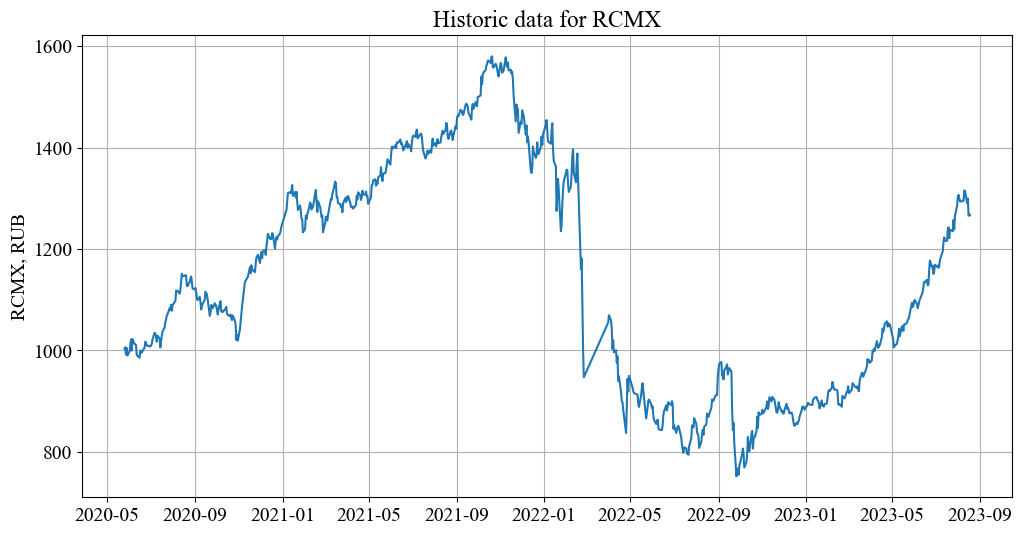

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df.date, df.price)
plt.ylabel('RCMX, RUB')
plt.title('Historic data for RCMX')
plt.grid()

In [6]:
from datetime import datetime
import datetime 

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [7]:
dfn = df.set_index('date').resample('D').asfreq()

dfn['Day'] = dfn.index.strftime('%A')

cond = dfn['Day'].isin(['Saturday', 'Sunday'])
dfn = dfn[~cond].fillna(method='ffill').reset_index()

df = dfn.sort_values('date', ascending=False).reset_index(drop=True)

### Количество предсказанных дней

In [8]:
amount_of_predicted_days = 14

## Разбивка на test и train выборки

In [9]:
df_test = df[:amount_of_predicted_days][['date', 'price']].rename(columns={'date':'ds','price':'y'})
df_train = df[amount_of_predicted_days:amount_of_predicted_days*10][['date', 'price']].rename(columns={'date':'ds','price':'y'})

In [10]:
df_for_comparison = pd.concat([df_train, df_test]).sort_values('ds').reset_index(drop=True)
df_for_comparison.head()

,ds,y
0,2023-02-06,926.0
1,2023-02-07,938.0
2,2023-02-08,932.0
3,2023-02-09,925.5
4,2023-02-10,922.5


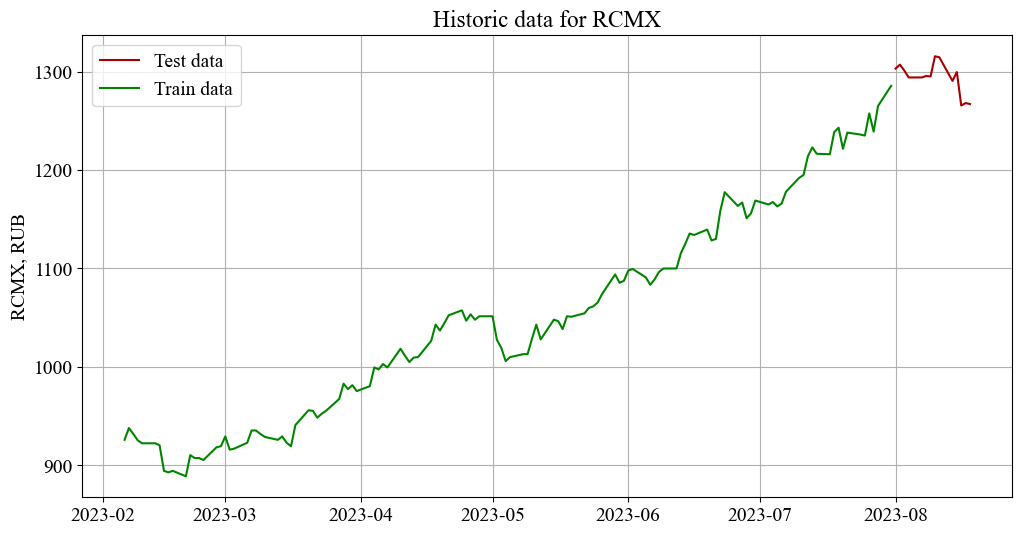

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df_test.ds, df_test.y, label='Test data', color='#A60000')
plt.plot(df_train.ds, df_train.y, label='Train data', color='#008500')
plt.ylabel('RCMX, RUB')
plt.title('Historic data for RCMX')
plt.legend()
plt.grid()

## Учет праздников в модели

In [12]:
holidays_dict = holidays.RUS(years=(2022,2023,2024))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
39,2024-03-08,Международный женский день
40,2024-05-01,Праздник Весны и Труда
41,2024-05-09,День Победы
42,2024-06-12,День России
43,2024-11-04,День народного единства


## Пример построения модели с параметрами

In [13]:
m = Prophet(holidays=df_holidays,
            changepoint_range=0.95,
            seasonality_prior_scale=10,
            changepoint_prior_scale=0.5).fit(df_train)

In [14]:
future = m.make_future_dataframe(periods=amount_of_predicted_days+4, freq='D') #+4 из-за выходных дней, когда биржка не торгует

In [15]:
forecast = m.predict(future)

In [16]:
cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']] \
.join(df_for_comparison.set_index('ds'), on='ds', how='inner')
cmp_df = cmp_df.round(2)
cmp_df.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2023-02-06,926.23,944.00,935.01,926.0
1,2023-02-07,924.47,943.30,933.58,938.0
2,2023-02-08,918.30,936.05,927.30,932.0
3,2023-02-09,915.50,933.73,924.87,925.5
4,2023-02-10,915.19,933.55,924.35,922.5


In [17]:
cmp_df['ae'] = abs(cmp_df['y'] - cmp_df['yhat'])
cmp_df['ape'] = 100*cmp_df['ae']/cmp_df['y']
cmp_df['se'] = (cmp_df['y'] - cmp_df['yhat'])**2

In [18]:
cmp_df.tail()

,ds,yhat_lower,yhat_upper,yhat,y,ae,ape,se
139,2023-08-14,1281.69,1367.86,1321.18,1290.5,30.68,2.377373,941.2624
140,2023-08-15,1279.90,1376.70,1326.26,1299.5,26.76,2.059254,716.0976
141,2023-08-16,1275.26,1384.31,1326.49,1265.5,60.99,4.819439,3719.7801
142,2023-08-17,1275.50,1391.48,1330.57,1268.0,62.57,4.934543,3915.0049
143,2023-08-18,1275.48,1406.87,1336.56,1267.0,69.56,5.490134,4838.5936


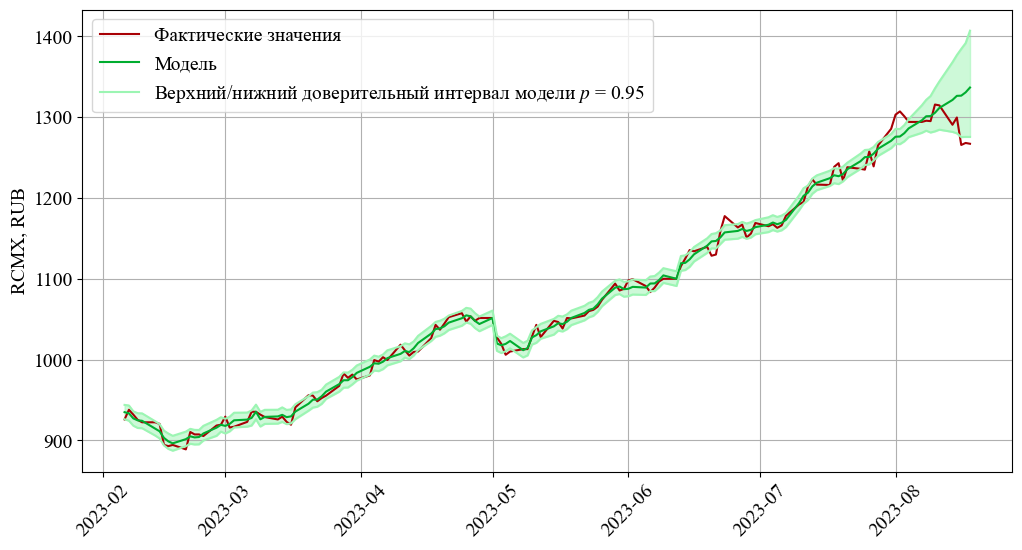

In [19]:
plt.figure(figsize=(12,6))
plt.plot(cmp_df.ds,cmp_df.y, label = 'Фактические значения', color='#A80005')
plt.plot(cmp_df.ds,cmp_df.yhat, label = 'Модель', color='#00AD2F')
plt.plot(cmp_df.ds,cmp_df.yhat_lower, 
label = 'Верхний/нижний доверительный интервал модели $p$ = 0.95', color='#9CF5B3')
plt.plot(cmp_df.ds,cmp_df.yhat_upper, color='#9CF5B3')
plt.fill_between(cmp_df.ds,cmp_df.yhat_lower,
cmp_df.yhat_upper, color='#9CF5B3',alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('RCMX, RUB')
plt.legend()
plt.grid()

## Выбор гиперпараметров модели методом дифференциальной эволюции и симплекс-методом

In [20]:
mins = np.array([0.8, 0.01, 0.001])
maxes = np.array([0.95, 10, 0.5])

# https://facebook.github.io/prophet/docs/diagnostics.html

def denormalize(x):
    return mins + x*(maxes-mins)

def normalize(x):
    return (x - mins) / (maxes-mins)

def minimize_foo_evol(x):
    point = denormalize(x)
    X = [0,0,0]
    X[0], X[1], X[2] = point
    try:
        m = Prophet(changepoint_range=X[0],
                    seasonality_prior_scale=X[1],
                    changepoint_prior_scale=X[2]).fit(df_train)

        future = m.make_future_dataframe(periods=amount_of_predicted_days, freq='D')
        forecast = m.predict(future)
        
        cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']].join(df_for_comparison.set_index('ds'), on='ds', how='inner')
        cmp_df = cmp_df.round(2)
        cmp_df['ae'] = abs(cmp_df['y'] - cmp_df['yhat'])
        cmp_df['ape'] = 100*cmp_df['ae']/cmp_df['y']
        cmp_df['se'] = (cmp_df['y'] - cmp_df['yhat'])**2
        
        crit = np.mean(abs(cmp_df[-amount_of_predicted_days:]['ape'])) # критерий оптимизации

    except:
        crit = np.nan
    return crit

In [21]:
from scipy.optimize import differential_evolution

In [22]:
bounds = [(0,1), (0,1), (0,1)]

### Оптимизация неградиентным методом

In [23]:
result_from_diff_evo = differential_evolution(minimize_foo_evol, bounds=bounds, 
                       args=(), strategy='best1exp', maxiter=35, 
                       popsize=13, tol=0.05, mutation=(0.4, 1.1), 
                       recombination=0.7, seed=None, 
                       disp=True, polish=False)

differential_evolution step 1: f(x)= 0.994876
differential_evolution step 2: f(x)= 0.994206
differential_evolution step 3: f(x)= 0.992462


In [24]:
result_from_diff_evo, denormalize(result_from_diff_evo.x)

(     fun: 0.9924616387960025
  message: 'Optimization terminated successfully.'
     nfev: 156
      nit: 3
  success: True
        x: array([0.30460945, 0.19384609, 0.63533083]),
 array([0.84569142, 1.94652242, 0.31803008]))

### Оптимизация градиентным методом, с начальными условиями после диф. эволюции

In [25]:
result = minimize(minimize_foo_evol, x0=denormalize(result_from_diff_evo.x), args=(), method='Nelder-Mead', bounds=bounds,
                                options={'maxiter':500, 'disp':True})

C:\Users\Stepan\AppData\Local\Temp\ipykernel_14616\2468652457.py:1: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(minimize_foo_evol, x0=denormalize(result_from_diff_evo.x), args=(), method='Nelder-Mead', bounds=bounds,


Optimization terminated successfully.
         Current function value: 0.999184
         Iterations: 149
         Function evaluations: 363


In [26]:
result, denormalize(result.x)

( final_simplex: (array([[0.84118559, 1.        , 0.32320104],
        [0.84118559, 1.        , 0.32320104],
        [0.84118559, 1.        , 0.32320104],
        [0.84118559, 1.        , 0.32320104]]), array([0.99918393, 0.99918393, 0.99918393, 0.99918393]))
            fun: 0.9991839345458896
        message: 'Optimization terminated successfully.'
           nfev: 363
            nit: 149
         status: 0
        success: True
              x: array([0.84118559, 1.        , 0.32320104]),
 array([ 0.92617784, 10.        ,  0.16227732]))

In [27]:
if result_from_diff_evo.fun >= result.fun:
    best_features = denormalize(result.x)
else:
    best_features = denormalize(result_from_diff_evo.x)
best_features

array([0.84569142, 1.94652242, 0.31803008])

In [28]:
m = Prophet(
changepoint_range=best_features[0],
seasonality_prior_scale=best_features[1],
changepoint_prior_scale=best_features[2]
).fit(df_for_comparison)

In [29]:
future = m.make_future_dataframe(periods=amount_of_predicted_days, freq='D')
forecast = m.predict(future)

In [30]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-06,931.088537,918.246892,948.773062,931.088537,931.088537,2.561140,2.561140,2.561140,2.561140,2.561140,2.561140,0.0,0.0,0.0,933.649676
1,2023-02-07,928.037592,917.410313,947.545944,928.037592,928.037592,4.591793,4.591793,4.591793,4.591793,4.591793,4.591793,0.0,0.0,0.0,932.629385
2,2023-02-08,924.986648,911.506501,940.274170,924.986648,924.986648,1.405115,1.405115,1.405115,1.405115,1.405115,1.405115,0.0,0.0,0.0,926.391763
3,2023-02-09,921.935703,908.237522,938.851982,921.935703,921.935703,1.830813,1.830813,1.830813,1.830813,1.830813,1.830813,0.0,0.0,0.0,923.766516
4,2023-02-10,918.884759,907.981596,937.267748,918.884759,918.884759,3.294072,3.294072,3.294072,3.294072,3.294072,3.294072,0.0,0.0,0.0,922.178831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2023-08-28,1323.418466,1308.247771,1344.725113,1313.146418,1333.377609,2.561140,2.561140,2.561140,2.561140,2.561140,2.561140,0.0,0.0,0.0,1325.979606
150,2023-08-29,1325.510666,1311.257973,1350.387914,1313.483897,1337.335292,4.591793,4.591793,4.591793,4.591793,4.591793,4.591793,0.0,0.0,0.0,1330.102459
151,2023-08-30,1327.602865,1308.552711,1348.977621,1313.433388,1341.704344,1.405115,1.405115,1.405115,1.405115,1.405115,1.405115,0.0,0.0,0.0,1329.007980
152,2023-08-31,1329.695064,1309.471704,1355.688838,1313.421948,1345.793026,1.830813,1.830813,1.830813,1.830813,1.830813,1.830813,0.0,0.0,0.0,1331.525877


In [31]:
cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']].join(df_for_comparison.set_index('ds'), on='ds', how='outer')
cmp_df = cmp_df.round(2)
cmp_df.tail(7)

,ds,yhat_lower,yhat_upper,yhat,y
147,2023-08-26,1295.36,1330.85,1312.39,NaN
148,2023-08-27,1297.44,1332.36,1314.48,NaN
149,2023-08-28,1308.25,1344.73,1325.98,NaN
150,2023-08-29,1311.26,1350.39,1330.10,NaN
151,2023-08-30,1308.55,1348.98,1329.01,NaN
152,2023-08-31,1309.47,1355.69,1331.53,NaN
153,2023-09-01,1310.89,1358.42,1335.08,NaN


In [32]:
cmp_df

,ds,yhat_lower,yhat_upper,yhat,y
0,2023-02-06,918.25,948.77,933.65,926.0
1,2023-02-07,917.41,947.55,932.63,938.0
2,2023-02-08,911.51,940.27,926.39,932.0
3,2023-02-09,908.24,938.85,923.77,925.5
4,2023-02-10,907.98,937.27,922.18,922.5
...,...,...,...,...,...
149,2023-08-28,1308.25,1344.73,1325.98,NaN
150,2023-08-29,1311.26,1350.39,1330.10,NaN
151,2023-08-30,1308.55,1348.98,1329.01,NaN
152,2023-08-31,1309.47,1355.69,1331.53,NaN


In [33]:
dfn = cmp_df.set_index('ds').resample('D').asfreq()

dfn['Day'] = dfn.index.strftime('%A')

cond = dfn['Day'].isin(['Saturday', 'Sunday'])
dfn = dfn[~cond].fillna(method='ffill').reset_index()

cmp_df = dfn.sort_values('ds', ascending=True).reset_index(drop=True)

In [34]:
cmp_df[-(amount_of_predicted_days)+4:]

,ds,yhat_lower,yhat_upper,yhat,y,Day
140,2023-08-21,1295.07,1324.89,1311.33,1267.0,Monday
141,2023-08-22,1300.13,1330.23,1315.46,1267.0,Tuesday
142,2023-08-23,1298.71,1330.06,1314.36,1267.0,Wednesday
143,2023-08-24,1300.98,1333.28,1316.88,1267.0,Thursday
144,2023-08-25,1303.79,1337.13,1320.44,1267.0,Friday
145,2023-08-28,1308.25,1344.73,1325.98,1267.0,Monday
146,2023-08-29,1311.26,1350.39,1330.10,1267.0,Tuesday
147,2023-08-30,1308.55,1348.98,1329.01,1267.0,Wednesday
148,2023-08-31,1309.47,1355.69,1331.53,1267.0,Thursday
149,2023-09-01,1310.89,1358.42,1335.08,1267.0,Friday


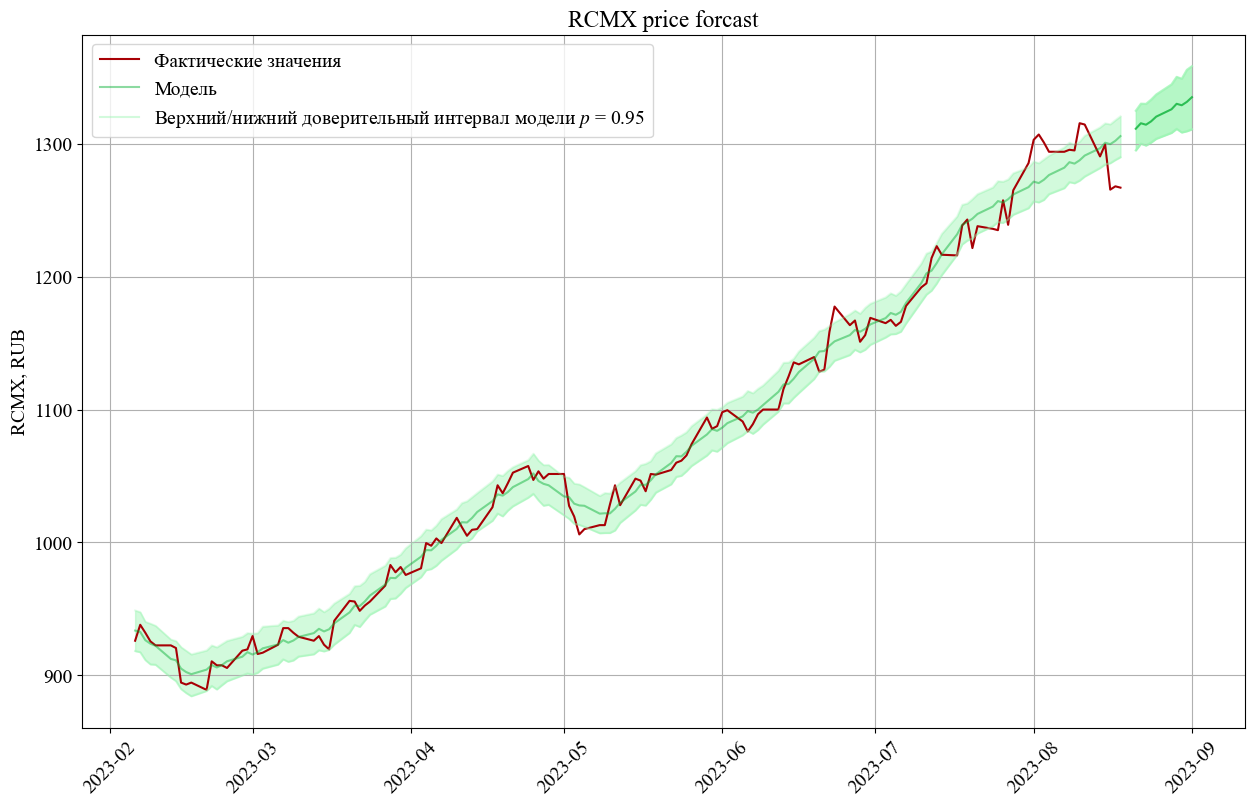

In [35]:
plt.figure(figsize=(15,9))

# фактические
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].y, 
         label = 'Фактические значения', color='#A80005')

# модель и фактические
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat, 
         label = 'Модель', color='#00AD2F',alpha=0.45)

plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_lower, 
        label = 'Верхний/нижний доверительный интервал модели $p$ = 0.95', color='#9CF5B3',alpha=0.45)
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_upper, color='#9CF5B3', alpha=0.25)

plt.fill_between(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_lower,
        cmp_df[:-amount_of_predicted_days+4].yhat_upper, color='#9CF5B3',alpha=0.45)

# модель прогноз
plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat, 
         color='#00AD2F',alpha=0.75)

plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_lower, 
        color='#9CF5B3',alpha=0.75)
plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_upper, color='#9CF5B3',alpha=0.75)

plt.fill_between(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_lower,
        cmp_df[-(amount_of_predicted_days)+4:].yhat_upper, color='#9CF5B3',alpha=0.75)

plt.xticks(rotation=45)
plt.ylabel('RCMX, RUB')
plt.title('RCMX price forcast')
plt.legend()
plt.grid()

### Значение фонды RCMX

In [36]:
cmp_df[-(amount_of_predicted_days)+4:].drop(columns=['y'])\
.rename(columns={'ds':'date', 'yhat_lower':'price_low', 'yhat_upper':'price_high', 'yhat':'price', 'Day':'day_name'})\
.reset_index(drop=True)

,date,price_low,price_high,price,day_name
0,2023-08-21,1295.07,1324.89,1311.33,Monday
1,2023-08-22,1300.13,1330.23,1315.46,Tuesday
2,2023-08-23,1298.71,1330.06,1314.36,Wednesday
3,2023-08-24,1300.98,1333.28,1316.88,Thursday
4,2023-08-25,1303.79,1337.13,1320.44,Friday
5,2023-08-28,1308.25,1344.73,1325.98,Monday
6,2023-08-29,1311.26,1350.39,1330.10,Tuesday
7,2023-08-30,1308.55,1348.98,1329.01,Wednesday
8,2023-08-31,1309.47,1355.69,1331.53,Thursday
9,2023-09-01,1310.89,1358.42,1335.08,Friday
